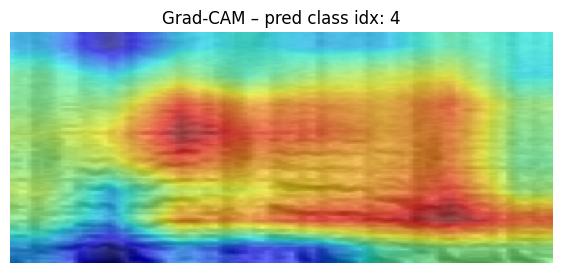

In [11]:
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from torchcam.methods import GradCAM
import pathlib

# ─── 1. spettrogramma di esempio ─────────────────────────────
test_pt = next(pathlib.Path('../data/processed').glob('pop*.pt'))
x = torch.load(test_pt).unsqueeze(0)           # (1,1,128,128)

# ─── 2. modello allenato ─────────────────────────────────────
model = resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, 7, 2, 3, bias=False)
model.fc    = torch.nn.Linear(512, 10)
model.load_state_dict(torch.load('../models/best_resnet18.pt', map_location='cpu'))
model.eval()

# ─── 3. Grad-CAM (layer3 → 8×8) ─────────────────────────────
cam = GradCAM(model, target_layer='layer3')
logits = model(x)
pred   = logits.argmax().item()
heat   = cam(pred, logits)[0]                  # (1, 8, 8)

# squeeze per togliere il canale già presente → (8,8)
heat = heat.squeeze()

# upsample a 128×128 → (128,128)
heat_up = F.interpolate(heat.unsqueeze(0).unsqueeze(0),
                        size=(128, 128),
                        mode='bilinear',
                        align_corners=False)[0, 0]

# ─── 4. normalizza spettrogramma per il plot ────────────────
spec = x.squeeze().numpy()
spec_norm = (spec - spec.min()) / (spec.max() - spec.min() + 1e-8)

# ─── 5. plot (spettro + CAM) ───────────────────────────────
plt.figure(figsize=(7,3))
plt.imshow(spec_norm, cmap='gray_r', origin='lower', aspect='auto')
plt.imshow(heat_up, alpha=0.6, cmap='jet', origin='lower', aspect='auto')
plt.axis('off')
plt.title(f"Grad-CAM – pred class idx: {pred}")
plt.show()